<a href="https://colab.research.google.com/github/vir-k01/ML-and-DL/blob/main/PokemonGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pokemon GAN (ref: https://www.kaggle.com/brkurzawa/151-pokemon-gan/data)

Goal: Train a GAN to produce images of Pokemon from random noise

Fetching Pokemon image dataset from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"virkaran","key":"36b745d28637a932c301fe55ba5491aa"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                               title                                                 size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  
christianlillelund/donald-trumps-rallies                          Donald Trump's Rallies                               720KB  2020-09-26 10:25:08            824  
heeraldedhia/groceries-dataset                                    Groceries dataset                                    257KB  2020-09-17 04:36:08           3816  
andrewmvd/trip-advisor-hotel-reviews                              Trip Advisor Hotel Reviews                             5MB  2020-09-30 08:31:20           2172  
balraj98/stanford-background-dataset                              Stanford Background Dataset                           17MB  2020-09-26 12:57:59            226  
nehaprabhavalkar/india

In [ ]:
! kaggle datasets download -d brkurzawa/original-150-pokemon-image-search-results

100% 20.3G/20.3G [08:32<00:00, 33.5MB/s]
100% 20.3G/20.3G [08:32<00:00, 42.5MB/s]


In [ ]:
! unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: pokemon/pokemon/Meowth/00000186.jpg  
  inflating: pokemon/pokemon/Meowth/00000187.png  
  inflating: pokemon/pokemon/Meowth/00000188.jpg  
  inflating: pokemon/pokemon/Meowth/00000189.png  
  inflating: pokemon/pokemon/Meowth/00000190.jpg  
  inflating: pokemon/pokemon/Meowth/00000191.jpg  
  inflating: pokemon/pokemon/Meowth/00000192.jpg  
  inflating: pokemon/pokemon/Meowth/00000193.jpg  
  inflating: pokemon/pokemon/Meowth/00000194.jpg  
  inflating: pokemon/pokemon/Meowth/00000195.jpg  
  inflating: pokemon/pokemon/Meowth/00000196.jpg  
  inflating: pokemon/pokemon/Meowth/00000197.jpg  
  inflating: pokemon/pokemon/Meowth/00000198.png  
  inflating: pokemon/pokemon/Meowth/00000199.jpg  
  inflating: pokemon/pokemon/Meowth/00000200.jpg  
  inflating: pokemon/pokemon/Meowth/00000201.png  
  inflating: pokemon/pokemon/Meowth/00000202.jpg  
  inflating: pokemon/pokemon/Meowth/00000203.jpg  
  inflating: pokemon/pokemon/Me

In [ ]:
import os # Handle working with files and directories
import tensorflow as tf # Loading images, storing them in tensors
import cv2
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Image preprocessing 
(Transparent BG to be padded; images to be resized; converted to .jpg)

In [ ]:
pokemon_dir = '../content/pokemon'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


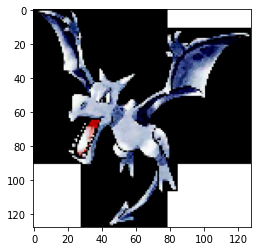

In [ ]:
# Convert an image to a jpeg
def convert_to_jpg(img_path):
    # Convert png to jpeg
    img = Image.open(img_path)
    if img.mode == 'RGBA':
        img.load()
        background = Image.new("RGB", img.size, (0,0,0))
        background.paste(img, mask=img.split()[3])
        img = np.array(background)
    else:
        img = img.convert('RGB')
        img = np.array(img)
    
    return img
        
# Resize image to 128x128
def resize_img(img):
    img = cv2.resize(img, (128,128))
    return img

# Normalize pixel values from -1 to 1
def normalize_img(img):
    img = img / 127.5 - 1
    return img

# Open an image, convert to jpeg, resize if needed
def open_convert(img_path):
    # png
    if img_path[-4:] == '.png':
        img = convert_to_jpg(img_path)
    # jpeg
    else:
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = np.array(img)

        
    # Convert to 128x128
    img = resize_img(img)
    
    # Normalize img
    img = normalize_img(img)
    
    # Return resized img
    return img

# Test
img = open_convert('../content/pokemon/Aerodactyl/00000048.png~original')
# img = Image.fromarray(img, 'RGB')
# img.save('my.png')
plt.imshow(img)
plt.show()

In [ ]:
# Contain images and labels
images = []
labels = []

# How many images per pokemon to load
images_per_pokemon = 5

# Keep track of current iteration
count = 0
# Iterate through each pokemon folder
for pkmn in os.listdir(pokemon_dir):
    pkmn_dir = os.path.join(pokemon_dir, pkmn)
    
    # Current number of images loaded for this pokemon
    curr_imgs = 0
    
    # Add each image to the list
    for img in sorted(os.listdir(pkmn_dir)):
        # Attempt to add image and label to list
        try:
            images.append(open_convert(os.path.join(pkmn_dir, img)))
            labels.append(pkmn)
        except (ValueError, OSError):
            continue
        count += 1
        if count % 1000 == 0:
            print('Current iteration: ' + str(count))
            
        # Increment num images loaded
        curr_imgs += 1
        if curr_imgs >= images_per_pokemon:
            break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


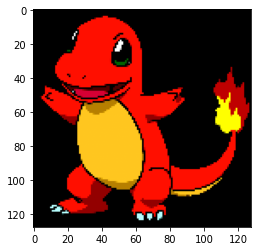

In [ ]:
plt.imshow(images[123])
plt.show()

Model Building

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, AveragePooling2D, Reshape, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

input_shape = (images[0].shape)

latent_dim = 100

def make_gen():
    Gen = Sequential()

    Gen.add(Dense(256, input_dim=latent_dim))
    Gen.add(LeakyReLU(alpha=0.2))
    Gen.add(BatchNormalization(momentum=0.8))
    Gen.add(Dense(512))
    Gen.add(LeakyReLU(alpha=0.2))
    Gen.add(BatchNormalization(momentum=0.8))
    Gen.add(Dense(1024))
    Gen.add(LeakyReLU(alpha=0.2))
    Gen.add(BatchNormalization(momentum=0.8))
    Gen.add(Dense(np.prod(input_shape), activation='tanh'))
    Gen.add(Reshape(input_shape))

    Gen.summary()
    
    noise = Input(shape=(latent_dim,))
#     noise = Input(shape=input_shape)
    img = Gen(noise)
    
    return Model(noise, img)
    
def make_discr():
    Discr = Sequential()

    Discr.add(Conv2D(128, (3, 3), strides=(2, 2), input_shape=input_shape))
    Discr.add(LeakyReLU(alpha=0.2))
    Discr.add(AveragePooling2D(pool_size = (4, 4)))
    Discr.add(Flatten())
    Discr.add(Dense(units=512, activation='relu'))
    Discr.add(Dense(units=1, activation='sigmoid'))
    
    Discr.summary()
    
    img = Input(shape=input_shape)
    validity = Discr(img)
    
    return Model(img, validity)

In [ ]:
optimizer = Adam(0.0002, 0.5)

Discr = make_discr()
Discr.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

Gen = make_gen()

z = Input(shape=(latent_dim,))
# z = Input(shape=input_shape)
img = Gen(z)

Discr.trainable = False

validity = Discr(img)

Combined = Model(z, validity)
Combined.compile(loss='binary_crossentropy', optimizer=optimizer)

batch_size = 128

epochs = 10000

sample_interval = 1000

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 63, 63, 128)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               14746112  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,750,209
Trainable params: 14,750,209
Non-trainable params: 0
____________________________________________

Displaying batch of images 

In [ ]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
#     noise = np.random.randn(r*c, 128, 128, 3)

    gen_imgs = Gen.predict(noise)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
#     for cnt in range(len(gen_imgs)):
#         imgname = 'epoch%dimg%d' % (epoch, cnt)
#         gen_imgs.to_csv(imgname, index=False)
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
#     fig.savefig("/%d.png" % epoch)
#     plt.close()
    plt.show()
    
def sample_big_images(epoch):
    noise = np.random.normal(0, 1, (5, latent_dim))
#     noise = np.random.randn(5, 128, 128, 3)
    
    gen_imgs = Gen.predict(noise)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Show 5 images
    for i in range(5):
        plt.imshow(gen_imgs[i, :, :, :])
        plt.show()


Main training loop (Runtime ~40min)

0 [D loss: 0.760618, acc.: 12.89%] [G loss: 0.292462]


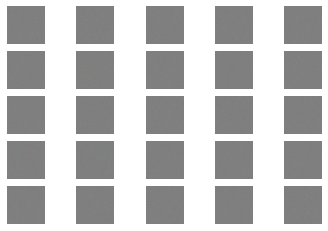

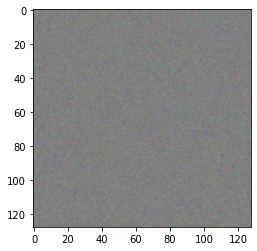

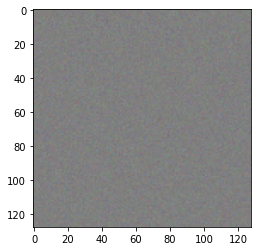

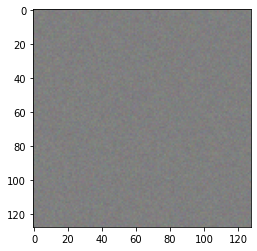

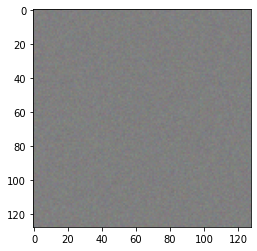

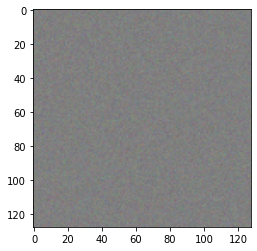

1000 [D loss: 0.138772, acc.: 94.92%] [G loss: 3.041399]


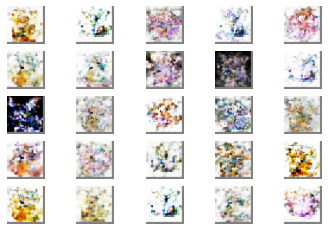

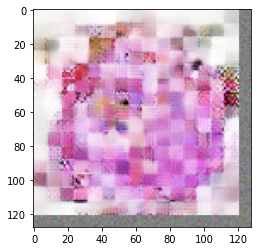

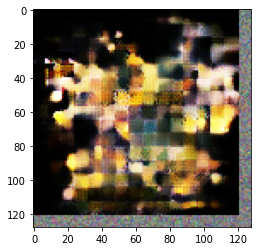

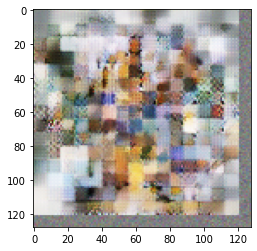

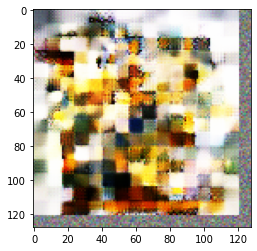

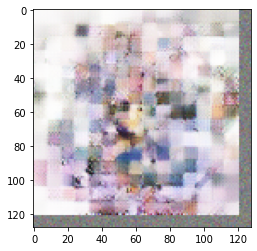

2000 [D loss: 0.175881, acc.: 92.97%] [G loss: 4.120589]


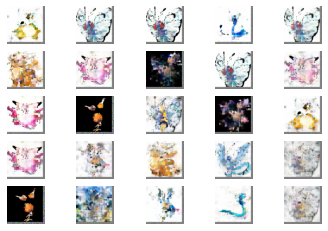

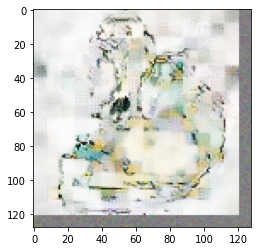

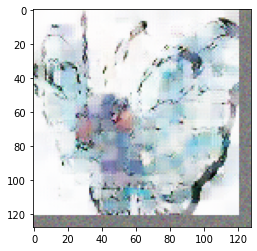

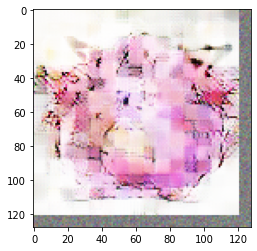

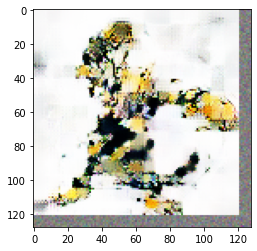

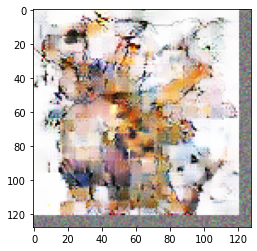

3000 [D loss: 0.092615, acc.: 97.27%] [G loss: 3.857517]


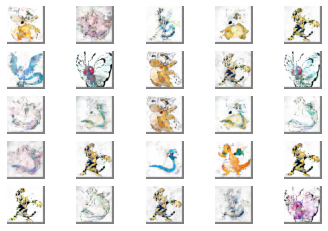

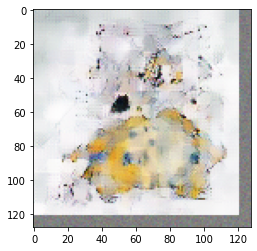

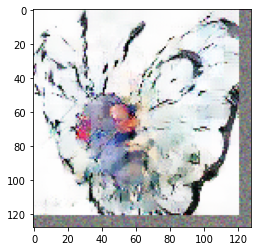

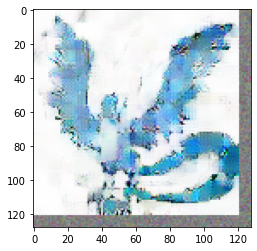

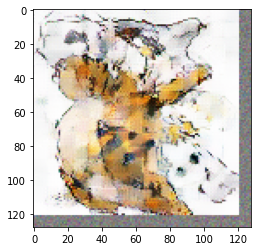

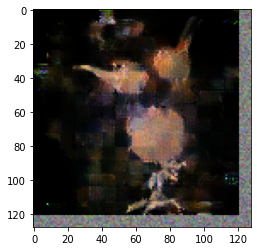

4000 [D loss: 0.088135, acc.: 97.27%] [G loss: 4.173665]


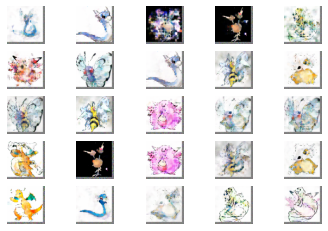

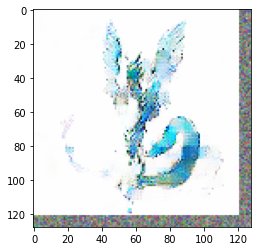

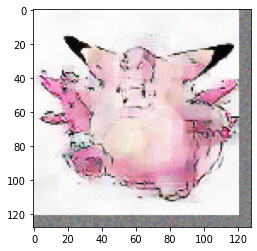

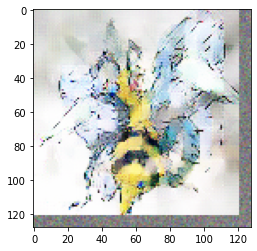

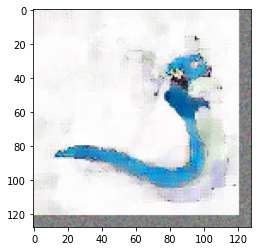

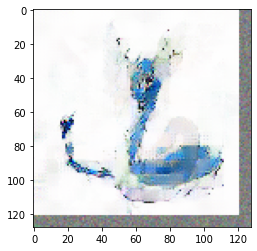

5000 [D loss: 0.121563, acc.: 95.70%] [G loss: 3.710602]


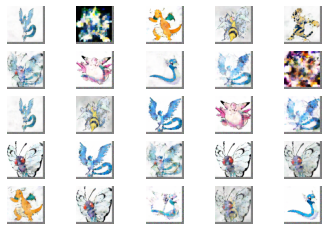

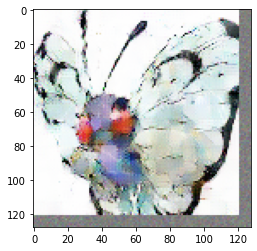

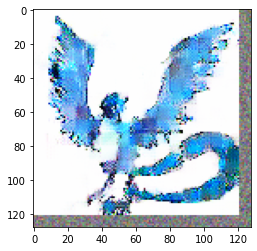

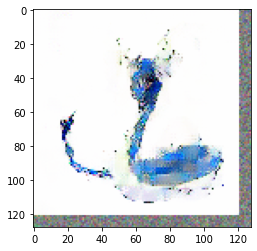

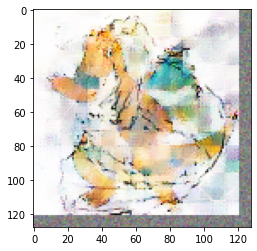

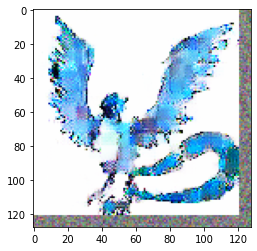

6000 [D loss: 0.129449, acc.: 96.09%] [G loss: 3.796588]


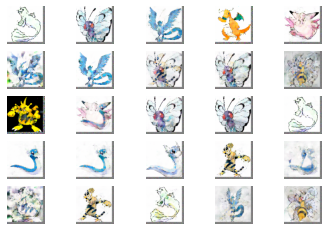

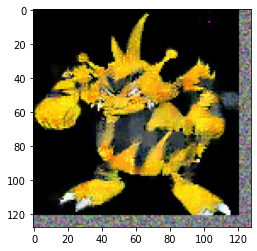

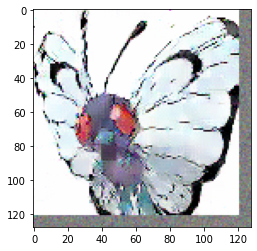

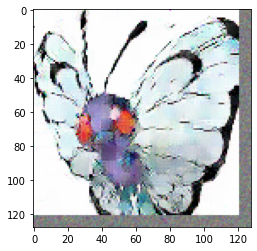

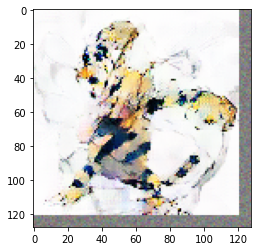

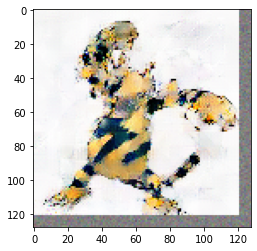

7000 [D loss: 0.065023, acc.: 98.44%] [G loss: 4.376877]


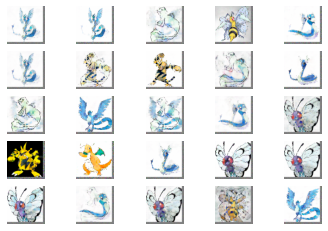

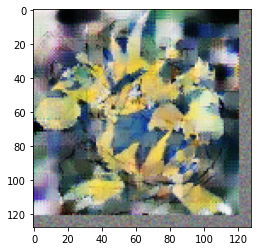

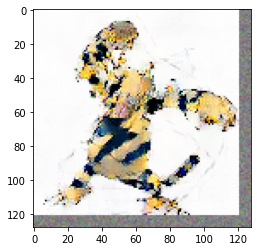

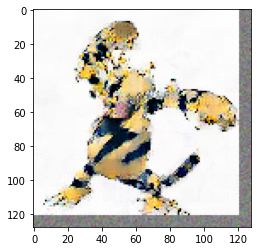

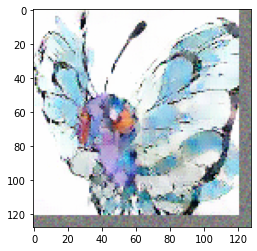

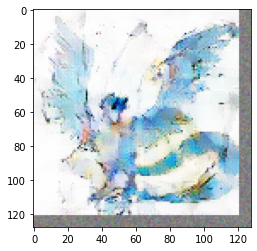

8000 [D loss: 0.092294, acc.: 96.09%] [G loss: 3.948422]


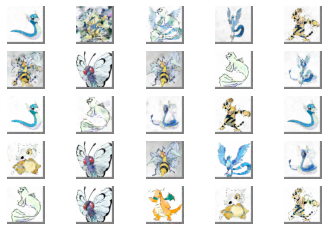

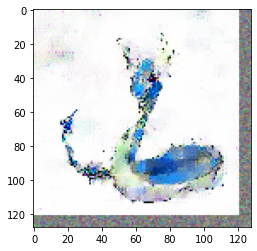

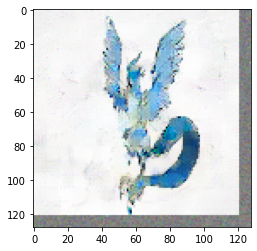

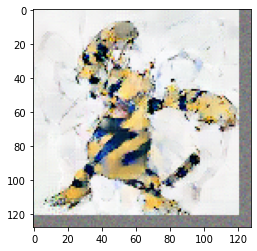

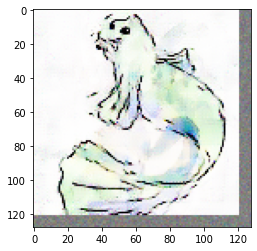

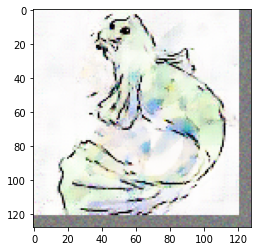

9000 [D loss: 0.104309, acc.: 96.48%] [G loss: 4.448436]


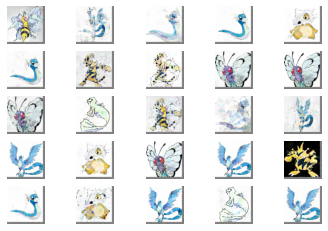

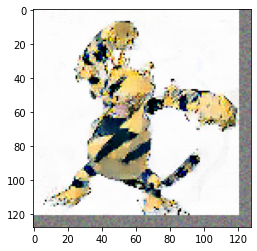

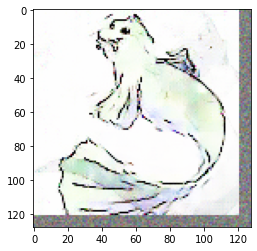

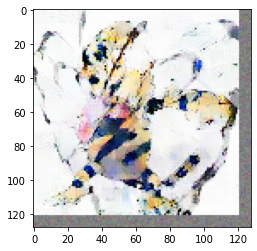

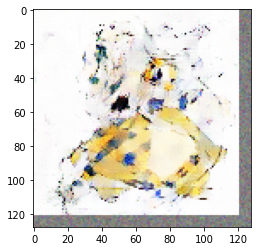

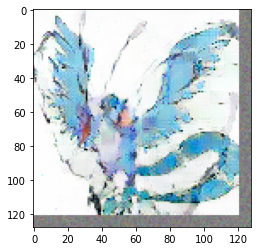

In [ ]:
for epoch in range(epochs):
    idx = np.random.randint(0, len(images), batch_size)
    imgs = np.array([images[j] for j in idx])
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
#     noise = np.random.randn(batch_size, 128, 128, 3)
    
    gen_imgs = Gen.predict(noise)
    
    d_loss_real = Discr.train_on_batch(imgs, valid)
    d_loss_fake = Discr.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
#     noise = np.random.randn(batch_size, 128, 128, 3)

    g_loss = Combined.train_on_batch(noise, valid)
    
    if epoch % sample_interval == 0:
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        sample_images(epoch)
        sample_big_images(epoch)